In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.svm import SVC

## Importation des données

In [2]:
data = pd.read_csv('df1.csv')

In [3]:
data = data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X = data.drop('TARGET', axis = 1)
y = data['TARGET'] 

## 1- DummyRegressor

In [4]:
from sklearn.dummy import DummyRegressor
set_config(display="diagram")  
# Le fractionnement des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DummyRegressor()
param_grid = {'strategy' : ['mean', 'median']}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# les étapes du pipeline :
pipe = Pipeline([("sm", SMOTE()), ("std", StandardScaler()),  ("dum", DummyRegressor())], verbose = True)
pipe.fit(X_train, y_train)
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
result = CV_gr.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 3) Processing sm, total=   0.3s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing dum, total=   0.0s


In [5]:
result.best_score_

-7.351111562403645e-06

In [6]:
bestParam = result.best_params_
bestParam

{'strategy': 'mean'}

## 2- KNeighborsClassifier

In [7]:
from sklearn.neighbors import KNeighborsClassifier

X = data.drop('TARGET', axis = 1)
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

model = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1,35),
             'weights': ['uniform', 'distance']} 

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# les étapes du pipeline :
pipe = Pipeline([("sm", SMOTE()), ('std', StandardScaler()),  ("knb", KNeighborsClassifier())], verbose = True)
pipe.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 3) Processing sm, total=   0.3s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing knb, total=   0.0s


Pipeline(steps=[('sm', SMOTE()), ('std', StandardScaler()),
                ('knb', KNeighborsClassifier())],
         verbose=True)

In [8]:
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold, refit=True, scoring='accuracy', return_train_score=False)
result = CV_gr.fit(X_train, y_train)

In [9]:
result.best_score_

0.917608899128807

In [10]:
bestParam = result.best_params_
bestParam

{'n_neighbors': 10, 'weights': 'uniform'}

## 3- XGBoots Classifier

In [9]:
from sklearn.metrics import fbeta_score, make_scorer
from xgboost import XGBClassifier
import xgboost

X = data.drop('TARGET', axis = 1)
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

model = XGBClassifier()
param_grid = {'nthread':[2], # lors de l'utilisation de l'hyperthread, xgboost peut devenir plus lent
              'objective':['binary:logistic'],
              'n_estimators': [600,800],
              'learning_rate': [0.01, 0.02],
              'gamma': [2, 5],             
              'max_depth': [ 4] }

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# les étapes du pipeline :
pipe = Pipeline([("sm", SMOTE()), ("std", StandardScaler()),  ("xgb", XGBClassifier())], verbose = True)
pipe.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 3) Processing sm, total=   0.3s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing xgb, total=  12.1s


Pipeline(steps=[('sm', SMOTE()), ('std', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))],
         verbose=True)

In [10]:
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, refit=True, cv=kfold,  verbose=1)
result = CV_gr.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [11]:
result.best_score_

0.9181843734195997

In [12]:
bestParam = result.best_params_
bestParam 

{'gamma': 2,
 'learning_rate': 0.02,
 'max_depth': 4,
 'n_estimators': 800,
 'nthread': 2,
 'objective': 'binary:logistic'}

 ## 4- Forêt aléatoire

In [11]:
from sklearn.ensemble import RandomForestClassifier
X = data.drop('TARGET', axis = 1)
y = data['TARGET']

# Le fractionnement des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


model = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators' :[200, 500], 
                   'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth' : [4,5,6,7,8],
                    'criterion' :['gini', 'entropy'] }

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# les étapes du pipeline :
pipe = Pipeline([("sm", SMOTE()), ("std", StandardScaler()),  ("clas", RandomForestClassifier())], verbose = True)
pipe.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 3) Processing sm, total=   0.3s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.1s
[Pipeline] .............. (step 3 of 3) Processing clas, total=   4.5s


Pipeline(steps=[('sm', SMOTE()), ('std', StandardScaler()),
                ('clas', RandomForestClassifier())],
         verbose=True)

In [12]:
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, refit=True, cv=kfold, verbose=1)
result = CV_gr.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [13]:
result.best_score_

0.9149760307726987

In [14]:
bestParam = result.best_params_
bestParam

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 200}

In [15]:
result.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=42)

## Le meilleur modèle choisi est XGBoost Classifier

In [16]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

## Calcul du score metier avec fbeta_score

In [17]:
from sklearn.metrics import fbeta_score, make_scorer
m_score =dict(beta=make_scorer(fbeta_score, beta=2))

## Evaluation des métriques par validation croisée avec les temps d'entrainement et les scores avec cross_validate

In [19]:
from xgboost import XGBClassifier
model = XGBClassifier(gamma = 2, learning_rate=0.02, max_depth= 4, n_estimators=800, objective='binary:logistic', nthread=2)

In [20]:
from sklearn.model_selection import cross_validate
model = XGBClassifier(gamma = 2, learning_rate=0.02, max_depth= 4, n_estimators=800, objective='binary:logistic', nthread=2)
eva_mdl = cross_validate(model, X_train, y_train, cv=5, scoring=m_score, return_train_score=True,return_estimator=True)

In [21]:
print(eva_mdl['fit_time'])

[25.82458925 26.37187862 24.97640538 28.38495278 57.96483231]


In [22]:
print(eva_mdl['score_time'])

[0.03124905 0.03124833 0.01562428 0.03125238 0.08902216]


In [23]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, nthread=2, num_parallel_tree=None,
              predictor=None, ...)

In [24]:
y_pred = model.predict(X_test)

In [25]:
model.score(X_train, y_train)

0.9173171436831454

In [26]:
model.score(X_test, y_pred)

1.0

In [27]:
print(model.predict_proba(X_train).round(2))

[[0.99 0.01]
 [0.89 0.11]
 [0.99 0.01]
 ...
 [0.64 0.36]
 [0.9  0.1 ]
 [0.98 0.02]]


In [28]:
print(model.predict_proba(X_test).round(2))

[[0.94 0.06]
 [0.95 0.05]
 [0.97 0.03]
 ...
 [0.88 0.12]
 [0.98 0.02]
 [0.95 0.05]]


In [29]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2133
           1       0.40      0.01      0.02       174

    accuracy                           0.92      2307
   macro avg       0.66      0.51      0.49      2307
weighted avg       0.89      0.92      0.89      2307



## La matrice de confusion

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[2130,    3],
       [ 172,    2]], dtype=int64)

## Calcul de l'AUC 
l’AUC PR est un indicateur de la performance globale du modèle 

In [31]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
#utilisez le modèle pour prédire la probabilité que la valeur y donnée soit 1
y_pred_proba = model.predict_proba(X_test)[::, 1]

#calculer l'AUC du modèle
auc = metrics.roc_auc_score (y_test, y_pred_proba).round(2)

#print AUC score
print(auc)

0.71


## Calcul de accuracy_score 
taux prédiction correcte à la fois les individus positifs et négatifs

In [32]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, model.predict(X_test)).round(2))

0.92


In [33]:
import shap
explainer = shap.Explainer(model, X)
shap_values = explainer(X_test)

 99%|===================| 2293/2307 [00:39<00:00]        

### Les features les plus importants en moyenne 

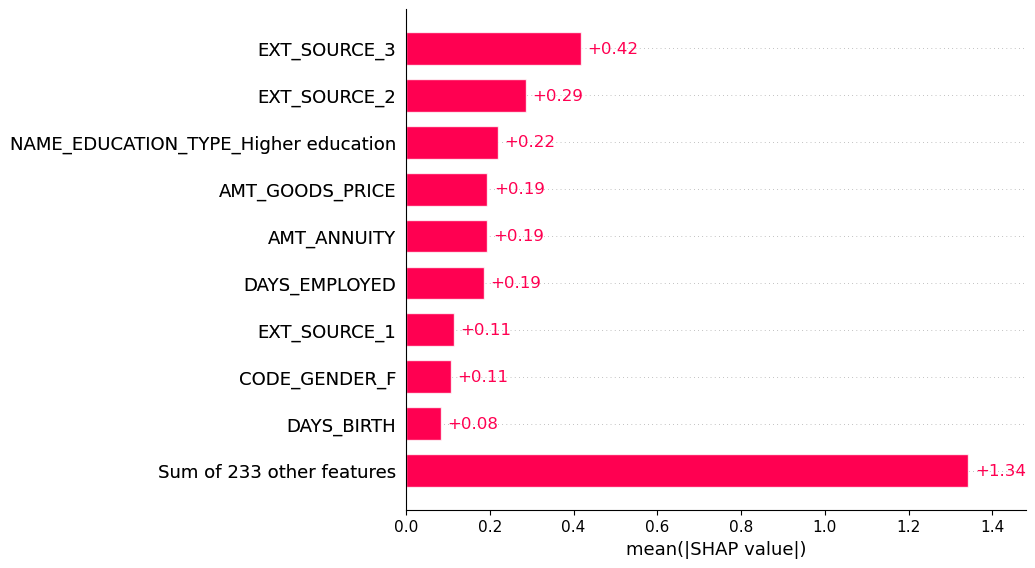

In [34]:
shap.plots.bar(shap_values)

## La courbe ROC Curve

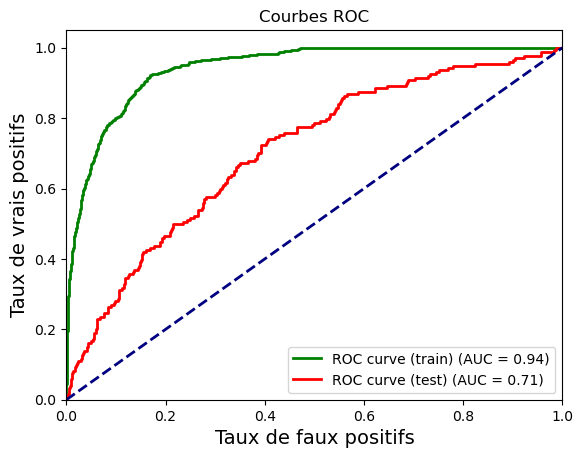

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
y_train_pred = model.predict_proba(X_train)[:, 1]
y_pred_proba = model.predict_proba(X_test)[:, 1]

[fpr_in, tpr_in, thr] = metrics.roc_curve(y_train, y_train_pred)
roc_auc_tr = auc(fpr_in, tpr_in)
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
roc_auc_test = auc(fpr, tpr)

plt.plot(fpr_in, tpr_in, color='green', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_tr)
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs', fontsize=14)
plt.ylabel('Taux de vrais positifs', fontsize=14)
plt.title('Courbes ROC')
plt.legend(loc="lower right")
plt.show()